# Age Classification Using Facial Images

#### Import Statements

In [1]:
import numpy as np 
import plotly.express as px 
import pandas as pd 
import cv2 
import os 
from glob import glob
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import pickle 

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
#added import for sgd
from tensorflow.keras.optimizers import SGD

# import dlib
import dlib

import dlib

from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb

import imutils

from tensorflow.keras.metrics import Precision, Recall

e:\virtualenv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Retrival and Cleaning

#### Converting the txt data to a dataframe

In [2]:
df_list = []
for file_name in glob("/age and gender prediction/project/data/AdienceAge/text reference to images/*.txt"):
    df_temp = pd.read_csv(file_name, sep="\t")
    df_list.append(df_temp)
df = pd.concat(df_list, axis=0, ignore_index=True)
del df_list

In [3]:
df.shape

(19370, 12)

#### Dropping null values

In [4]:
df = df.dropna()

In [5]:
df.shape

(18591, 12)

#### Using the details of dataframe to get the image path

In [6]:
df['image_path'] = df[['user_id', 'face_id', 'original_image']].apply(
    lambda x: os.path.join('/age and gender prediction/project/data/AdienceAge/aligned', f"{x[0]}", f"landmark_aligned_face.{x[1]}.{x[2]}"), axis=1)

#### Narrowing the classification to *Eight Age Classes*

In [7]:
df.age.value_counts()

(25, 32)     4953
(0, 2)       2488
(38, 43)     2293
(4, 6)       2140
(8, 12)      2119
(15, 20)     1642
(60, 100)     867
(48, 53)      825
35            293
13            168
22            149
34            105
23             96
45             88
(27, 32)       77
55             76
36             56
(38, 42)       46
None           40
57             24
3              18
29             11
(38, 48)        6
58              5
2               3
(8, 23)         1
42              1
46              1
Name: age, dtype: int64

In [8]:
age_mapping = [('(0, 2)', 'Kid'), ('2', 'Kid'), ('3', 'Kid'), ('(4, 6)', 'Kid'), ('(8, 12)', 'Kid'), ('13', 'Kid'), ('22', 'Youth'), ('(8, 23)','Youth'), ('23', 'Youth'),
               ('(15, 20)', 'Youth'), ('(25, 32)', 'Youth'), ('(27, 32)', 'Youth'), ('32', 'Youth'), ('34', 'Youth'), ('29', 'Youth'), ('(38, 42)', 'Adult'), ('35', 'Adult'),
               ('36', 'Adult'), ('42', 'Adult'), ('45', 'Adult'), ('(38, 43)', 'Adult'), ('(38, 42)', 'Adult'), ('(38, 48)', 'Adult'), ('46', 'Adult'), ('(48, 53)', 'Adult'),
               ('55', 'Adult'), ('56', 'Adult'), ('(60, 100)', 'Old'), ('57', 'Old'), ('58', 'Old')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}

drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]
df = df.drop(labels=drop_labels, axis=0) #droped None values
ind = df[df['age'].str.startswith("(")].index
df.drop(ind, axis = 0, inplace = True)
df = df[df['age'] != '35']
df = df[df['age'] != '55']

e:\virtualenv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
df['age'].value_counts()

Kid      6770
Youth    6662
Adult    3562
Old       862
Name: age, dtype: int64

In [10]:
new_df = df[['age', 'gender', 'x', 'y', 'dx', 'dy','image_path']]

In [11]:
del df

#### Using LabelEncoder to obtain targets in integers

In [12]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
new_df['age'] = le.fit_transform(new_df['age'])

#### Dumping the same for future usage

In [13]:
with open('Adience_age_encoder.pkl','wb') as pkl_file:
    pickle.dump(le, pkl_file)

## Image Preprocessing

#### Preparing to split for train and test set

In [14]:
X = new_df[['image_path']].values 
y = new_df[['age']].values 

In [15]:
set(y.flatten().tolist())

{0, 1, 2, 3}

#### Train Test Split

In [16]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Assigning uniform image extensions and resizing

In [17]:
def preprocess_image(individual_path):
    img = tf.io.read_file(np.array(individual_path).ravel()[0]) 
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [227,227])
    return img 

## Face Detection and Landmark Detection

#### Detecting faces using cv2's face_cascade function, and overwriting with the original image

In [18]:
def yield_training_values(X_train,y_train):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    fa = FaceAligner(predictor, desiredFaceWidth=256)
    for image_path, value in zip(X_train, y_train):
        imageP = image_path[0].decode("utf-8")
        img= cv2.imread(imageP, 1)
        denoised_image = cv2.fastNlMeansDenoisingColored(img, None, 5, 6, 7, 21)

        gray = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
        # Detect the face
        rects = detector(gray, 1)
        # Detect landmarks for each face
        
        try:
            for rect in rects:
                faceAligned = fa.align(img, gray, rect)

            gray1 = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2GRAY)
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            faces = face_cascade.detectMultiScale(gray1, 1.3, 5)

            try:
                for (x,y,w,h) in faces:
                    # for putting rectangle on face
                    #cv2.rectangle(faceAligned, (x,y), (x+w, y+h), (0, 255, 0),3)
                    roi_color = faceAligned[y:y+h, x:x+w]
                    cv2.imwrite(imageP , roi_color)
            except:
                continue
        except:
            continue
        
        image = preprocess_image([bytes(imageP, 'utf-8')])
        yield image, value 

#### Using train and test for the model

In [19]:
ds_train = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_train, y_train],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([227, 227, 3], [1]))


ds_test = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_test, y_test],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([227, 227, 3], [1]))

### Shuffling the data

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE)

## Model Implementation

### Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2,0.2),
])

### Model Building

In [22]:
model = keras.models.Sequential([
    data_augmentation,
    keras.layers.Conv2D(filters=96, kernel_size=(7,7), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=((2,2))),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=((2,2))),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

In [23]:
checkpoint_path = "model_checkpoints_weights/adience/age_checkpoint_13mar.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [24]:
#adam = tf.keras.optimizers.Adam(learning_rate=0.001) 
sgd = SGD(learning_rate=0.001)
model.compile(optimizer=sgd, loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

### Training the Model

In [25]:
history = model.fit(ds_train, validation_data=ds_test, epochs=20, callbacks = [checkpoint_callback])

Epoch 1/20
    447/Unknown - 27251s 56s/step - loss: 6.8711 - accuracy: 0.3464
Epoch 1: val_loss improved from inf to 6.30742, saving model to model_checkpoints_weights/adience\age_checkpoint_13mar.ckpt
447/447 [==============================] - 34186s 72s/step - loss: 6.8711 - accuracy: 0.3464 - val_loss: 6.3074 - val_accuracy: 0.3928
Epoch 2/20
447/447 [==============================] - ETA: 0s - loss: 6.3983 - accuracy: 0.3551
Epoch 2: val_loss improved from 6.30742 to 6.16408, saving model to model_checkpoints_weights/adience\age_checkpoint_13mar.ckpt
447/447 [==============================] - 586s 1s/step - loss: 6.3983 - accuracy: 0.3551 - val_loss: 6.1641 - val_accuracy: 0.3894
Epoch 3/20
447/447 [==============================] - ETA: 0s - loss: 6.2138 - accuracy: 0.3615
Epoch 3: val_loss improved from 6.16408 to 6.07589, saving model to model_checkpoints_weights/adience\age_checkpoint_13mar.ckpt
447/447 [==============================] - 574s 1s/step - loss: 6.2138 - accuracy:

447/447 [==============================] - ETA: 0s - loss: 5.9841 - accuracy: 0.3694
Epoch 5: val_loss improved from 5.97892 to 5.89374, saving model to model_checkpoints_weights/adience\age_checkpoint_13mar.ckpt
447/447 [==============================] - 594s 1s/step - loss: 5.9841 - accuracy: 0.3694 - val_loss: 5.8937 - val_accuracy: 0.4009
Epoch 6/20
447/447 [==============================] - ETA: 0s - loss: 5.8842 - accuracy: 0.3787
Epoch 6: val_loss improved from 5.89374 to 5.80772, saving model to model_checkpoints_weights/adience\age_checkpoint_13mar.ckpt
447/447 [==============================] - 665s 1s/step - loss: 5.8842 - accuracy: 0.3787 - val_loss: 5.8077 - val_accuracy: 0.3841
Epoch 7/20
447/447 [==============================] - ETA: 0s - loss: 5.7981 - accuracy: 0.3813
Epoch 7: val_loss improved from 5.80772 to 5.72533, saving model to model_checkpoints_weights/adience\age_checkpoint_13mar.ckpt
447/447 [==============================] - 596s 1s/step - loss: 5.7981 - ac

In [26]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [27]:
model.save("models/adience/age_13mar.h5") 

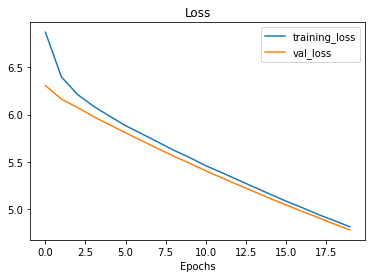

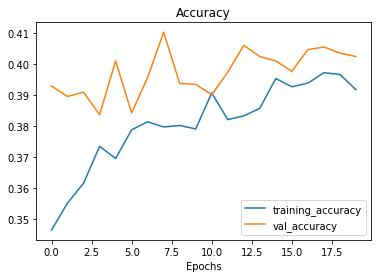

In [28]:
plot_loss_curves(history)

In [29]:
model.evaluate(ds_test)

112/112 [==============================] - 29s 258ms/step - loss: 4.7810 - accuracy: 0.4023


[4.7810258865356445, 0.40229561924934387]

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 96)        14208     
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)     